In [190]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
from sklearn import linear_model as lm
import datetime as dt


# Coronavirus Dataset
The coronavirus dataset we are using consists of the data set containing information about each county including its population, the populations' underlying conditions, and other relevant information about its demographics. We are also using the data set containing the most recent number of confirmed cases in the US as of 4/18/20.

In [191]:
counties = pd.read_csv('abridged_couties.csv')

In [192]:
time_confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')

We will only consider counties in the 50 states (stateFIPS 1-56) and will merge both tables based on their countyFIPS. We will also only consider data of confirmed cases from 4/18/20 as the target data for our model.

In [193]:
# Get only counties from the 50 states
counties['STATEFP'] = counties['STATEFP'].fillna(1000)
counties = counties[counties['STATEFP'] <= 56]

# Get only 4/18/20 data from time_confirmed
time_confirmed_recent = time_confirmed[['FIPS','3/11/20', '4/4/20', '4/11/20', '4/18/20']]

In [194]:
# Merge tables based on countyFIPS
counties['countyFIPS'] = counties['countyFIPS'].astype(int) # convert from type object to int
counties_data = counties.merge(time_confirmed_recent, how='inner', left_on='countyFIPS', right_on='FIPS')
counties_data.head(5)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,FIPS,3/11/20,4/4/20,4/11/20,4/18/20
0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737495.0,0.4354,NaN,NaN,NaN,1001.0,0,12,19,25
1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737495.0,0.2162,NaN,NaN,NaN,1003.0,0,29,66,109
2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737495.0,0.9959,6.08,5400.0,18241.0,1005.0,0,2,9,18
3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737495.0,0.6003,2.75,14980.0,6120.0,1007.0,0,4,13,26
4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737495.0,0.4242,7.21,31850.0,25233.0,1009.0,0,10,12,20


Rename 4/18/20 column to "Cases". Add weekly and monthly growth. 

In [195]:
counties_data['Weekly'] = counties_data["4/11/20"] - counties_data["4/4/20"]
counties_data['Monthly'] = counties_data["4/11/20"] - counties_data["3/11/20"]
counties_data = counties_data.rename(columns={"4/18/20": 'Cases'})

We will split the data into training and test sets.

In [196]:
training_data, test_data = sklearn.model_selection.train_test_split(counties_data, train_size = 0.7, test_size = 0.3, random_state=42)
print('Train:', training_data.shape, 'Test:', test_data.shape)

Train: (2198, 94) Test: (942, 94)


# Exploratory Data Analysis

We begin by examining a distribution plot of the number of coronavirus cases.

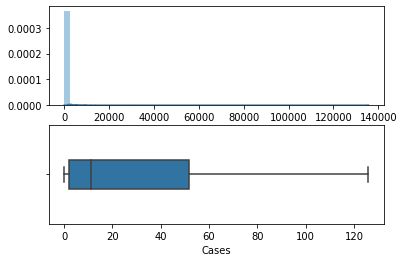

<Figure size 720x432 with 0 Axes>

In [197]:
fig, axs = plt.subplots(nrows=2)
plt.figure(figsize = (10, 6))

sns.distplot(
    training_data['Cases'], 
    ax=axs[0]
)
sns.boxplot(
    training_data['Cases'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

The distribution plot shows that the data has numerous clear outliers. Based on the box plot, we see that a majority of the cases are between around 2 and 55 coronavirus cases in the counties. 

For this model, we will remove outliers from the data since outliers of counties that have significantly higher number of cases than other counties, such as New York, to make our visualizations clear and our model more accurate. We will remove counties with more than 10,000 cases.

In [198]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):  
    return data[(data[variable] < upper) & (data[variable] > lower)]

training_data = remove_outliers(training_data, 'Cases', upper=10000)

### Number of Cases vs Rural-Urban Continuum Code 2013

Next, we visualize the association between '# cases' and 'Rural-Urban Continuum Code 2013'. The code is a form of classification that "distinguishes metropolitan counties by the size of their metro area, and nonmetropolitan counties by the degree of urbanization and adjacency to a metro area or areas" (SEER Datasets).

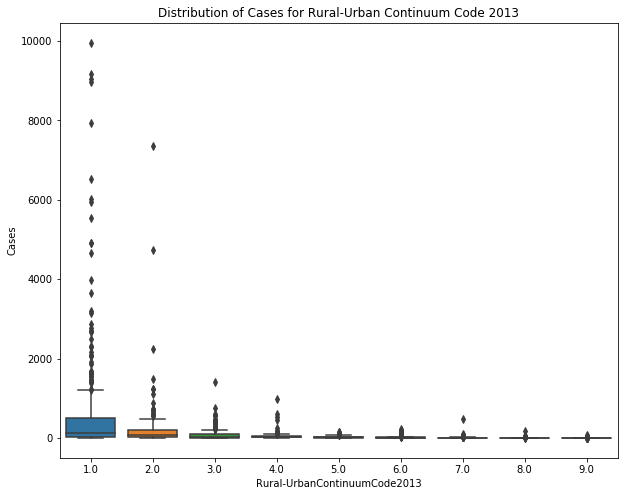

In [199]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = 'Rural-UrbanContinuumCode2013', y = 'Cases', data = training_data)
plt.title('Distribution of Cases for Rural-Urban Continuum Code 2013');

The boxplot shows that there is an association between population size/seclusion and the number of cases. Urban counties with high population size and low seclusion have more cases than rural counties with low population size and high seclusion.

### Population Estimate 2018 vs. # of Cases

We visualize the association between the population of the counties and the number of cases in each county.

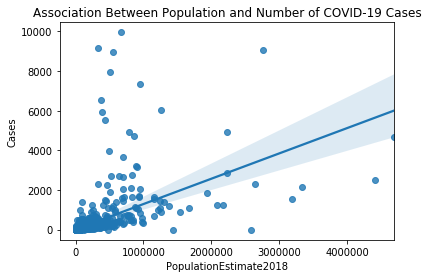

In [200]:
sns.regplot(x='PopulationEstimate2018', 
    y='Cases', 
    data=training_data,)
plt.title('Association Between Population and Number of COVID-19 Cases');

There seems to be a slight linear association between the two variables, though there are sparsely scattered outliers in the data. 

# Modeling

Using the data from 4/11/20 and earlier, we will fit a linear regression to predict the number of cases a week later, 4/18/20, which we can compare against actual data from 4/18/20. 

In [201]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [202]:
def process_data(data):
    """Process the data for a guided model."""

#     data = data.fillna({'stay at home':0})
#     data = data.fillna({'HeartDiseaseMortality':0})
#     data = data.fillna({'MedicareEnrollment,AgedTot2017': 0})
    data = data.fillna(0)
    
#     features = counties_data.columns[12:]
#     data = data[features]
    # Transform Data, Select Features
    data = select_columns(data, 'Cases',
                          'PopulationEstimate2018',
                          'Rural-UrbanContinuumCode2013',
                          'DiabetesPercentage',
                          'Smokers_Percentage',
                          'stay at home',
                          'RespMortalityRate2014',
#                           '#FTEHospitalTotal2017',
#                           '#ICU_beds',
                          'PopMale>842010',
                          'PopFmle>842010',
#                           'PopFmle75-842010',
#                           'PopMale75-842010',
                          'MedicareEnrollment,AgedTot2017',
                          'MedianAge2010',
#                           'PopulationDensityperSqMile2010',
#                           'StrokeMortality',
                          '4/11/20',
                          '3/11/20',
                          'Weekly',
                          'Monthly'
                         )

    # Return predictors and response variables separately
    X = data.drop(['Cases'], axis = 1)
    y = data.loc[:, 'Cases']
    
    return X, y

In [203]:
x_train, y_train = process_data(training_data)
x_test, y_test = process_data(test_data)

In [204]:
model = lm.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [205]:
y_predicted_train = model.predict(x_train)
y_predicted_test = model.predict(x_test)

In [206]:
training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
training_rmse, test_rmse

(54.11119031785855, 93.63497089889627)

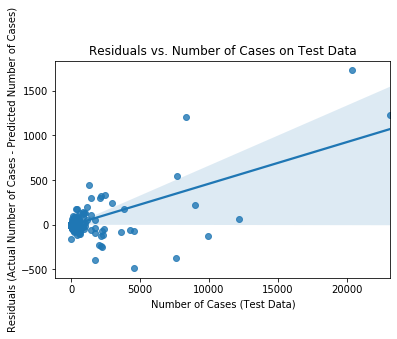

In [207]:
residuals = y_test - y_predicted_test
ax = sns.regplot(y_test, residuals)

ax.set_xlabel('Number of Cases (Test Data)')
ax.set_ylabel('Residuals (Actual Number of Cases - Predicted Number of Cases)')
ax.set_title("Residuals vs. Number of Cases on Test Data");

The residuals seem to be relatively randomly scattered both above and below the regression line, except for a few sparse outliers.

Two features that significantly improved our predictions were 'Weekly' and 'Monthly' growth.

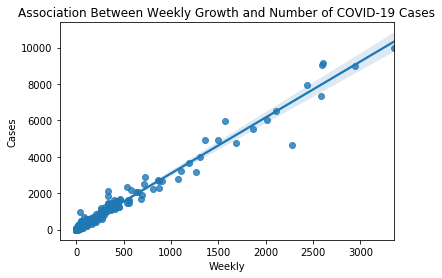

In [208]:
sns.regplot(x='Weekly', 
    y='Cases', 
    data=training_data,)
plt.title('Association Between Weekly Growth and Number of COVID-19 Cases');

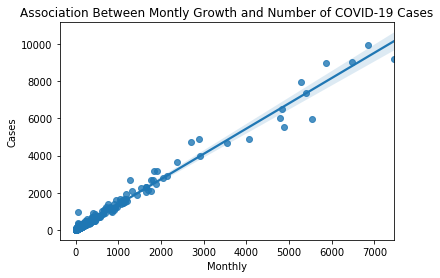

In [209]:
sns.regplot(x='Monthly', 
    y='Cases', 
    data=training_data,)
plt.title('Association Between Montly Growth and Number of COVID-19 Cases');

We see from the two plots that there is a strong relation between the two growths and the number of COVID-19 cases.

# Further Analysis: SIR

For funsies, we tried an SIR model too! We began with a start date of 4/11/20 and ended with 4/18 to predicted the number infected cases in each county.

Since we do not have the data on the number of recovered individuals, we began with 0 recovered individuals. We used a contact rate based on outside research of 0.21 and if the county implemented a stay at home policy, we would set the contact rate to .12 and we used a recovery rate of .070186 by dividing the total number of recovered cases by the total number of confirmed cases in the US.

In [218]:
sir_counties = counties.copy()
ordinal_times = sir_counties.iloc[:, 75: -4].columns

In [219]:
for t in ordinal_times:
    sir_counties[t] = sir_counties[t].fillna(0).astype(int).apply(lambda x: pd.datetime.fromordinal(x) if x >= 1 else np.nan)
    

We will only consider counties in the 50 states (stateFIPS 1-56) and will merge both tables based on their countyFIPS. We will also only consider data of confirmed cases from 4/18/20.

In [220]:

# Get only counties from the 50 states
sir_counties['STATEFP'] = sir_counties['STATEFP'].fillna(1000)
sir_counties = sir_counties[sir_counties['STATEFP'] <= 56]

# Get only 4/18/20 data from time_confirmed
# time_confirmed_recent = time_confirmed[['FIPS', '4/16/20',  '4/17/20', '4/18/20']]

In [221]:
# Merge tables based on countyFIPS
sir_counties['countyFIPS'] = sir_counties['countyFIPS'].astype(int) # convert from type object to int
sir_counties_data = sir_counties.merge(time_confirmed, how='inner', left_on='countyFIPS', right_on='FIPS')

#Get rid of line: may be missing certain counties because of lack of statefip, countyfp etc, will do reflection

In [222]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
results = []

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

for _, row in sir_counties_data.iterrows():
    # Total population, N in county
    N = row['PopulationEstimate2018']
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = row['4/11/20'], 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta = .21 # contact rate based on researched data
    startdate = dt.datetime(2020, 4, 11)
    if row['stay at home'] and row['stay at home'] < startdate:
        beta = .1205
    gamma = .070186 # recovery rate is number of total recovered / number of total confirmed cases in the US
    # A grid of time points (in days)
    t = np.linspace(0, 8, 8)
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    results.append(I)

In [223]:
df = pd.DataFrame(results).rename(columns={0:'4/11/20', 1:'4/12/20', 2:'4/13/20', 3:'4/14/20', 4:'4/15/20', 
                                           5:'4/16/20', 6:'4/17/20',  7:'Predicted 4/18/20'})
df['Actual # Cases'] = sir_counties_data['4/18/20']

In [224]:
rmse(df['Predicted 4/18/20'], df['Actual # Cases'])

162.9620476874091

Though the rmse is higher than that of the linear regression, this may be because we had no county-level data on recovery rate, and the contact rates may be slightly inaccurate. We also do not consider other underlying factors. 

(-5000, 7500)

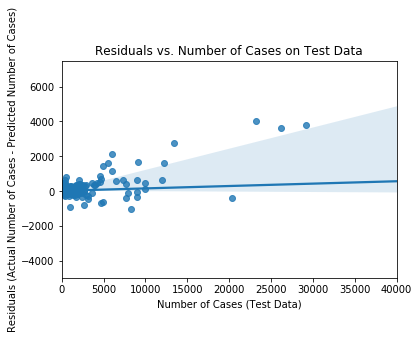

In [231]:
residuals = df['Predicted 4/18/20'] - df['Actual # Cases']
ax = sns.regplot(df['Actual # Cases'], residuals)

ax.set_xlabel('Number of Cases (Test Data)')
ax.set_ylabel('Residuals (Actual Number of Cases - Predicted Number of Cases)')
ax.set_title("Residuals vs. Number of Cases on Test Data");
plt.xlim(0,40000)
plt.ylim(-5000,7500)

Despite the greater rmse, the residuals are more randomly scattered and thus, in the future, if further analysis was considered, we would consider advancing our SIR model with more features.